In [1]:
import torch
import torch.nn as nn
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from ipywidgets import interact

from src.data.box import GravityHoleBall
from src.data.generate import generate_gravity_hole_ball_images

from src.utils.utils import add_spatial_encoding
from src.utils.node import  BatchGetterMultiImages, train_convnode_with_batch
from src.utils.viz import  display_convnode_trajectory

from src.models.convnode import ConvNodeWithBatch#, LatentRegularizerLoss


In [2]:
MARGIN_MIN = 5
MIN_INIT_VELOCITY = 200.
WIDTH, HEIGHT = 28, 28
RADIUS = 3

infos = {
    "MARGIN_MIN":MARGIN_MIN,
    "MIN_INIT_VELOCITY":MIN_INIT_VELOCITY,
    "WIDTH":WIDTH,
    "HEIGHT":HEIGHT,
    "RADIUS":RADIUS
}

x = WIDTH/4.
y = HEIGHT/4.
vx = 0.
vy = 0.

box = GravityHoleBall(x, y, vx, vy, (WIDTH, HEIGHT),RADIUS)


Num_pos_velocity = 1
N = 300
N_frames = 300 + Num_pos_velocity
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)
print("-"*50)
print("Generating images...")
images = generate_gravity_hole_ball_images(box, N=N, N_frames=N_frames, dt=dt, infos=infos).reshape(-1, 1, HEIGHT, WIDTH)
print(images.shape)
# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
images = torch.from_numpy(add_spatial_encoding(images)).float().reshape(N, -1, 3, HEIGHT, WIDTH)
print(images.shape)


--------------------------------------------------
Generating images...


100%|██████████| 300/300 [00:09<00:00, 31.32it/s]


(90300, 1, 28, 28)
torch.Size([300, 301, 3, 28, 28])


In [3]:
print("-"*50)
print("Creating model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
size = 28
latent_dim = 30
in_channels = 3
ode_data_dim = latent_dim
ode_hidden_dim = 128
augment_dim=0
time_dependent=False
ode_non_linearity='relu' 
conv_activation=nn.ReLU()
latent_activation=None
stack_size=1

conv_ode = ConvNodeWithBatch(device, size, latent_dim, in_channels,
    ode_hidden_dim, ode_data_dim, augment_dim=augment_dim, time_dependent=time_dependent,
    ode_non_linearity=ode_non_linearity, ode_linear_layer=False, conv_activation=conv_activation,
    latent_activation=latent_activation, stack_size=stack_size)

# pathConvODE = "models/AE_ODE/ConvODE/conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_with_lambda_decay.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
# print(conv_ode.load_state_dict(torch.load(pathConvODE)))

--------------------------------------------------
Creating model...
--------------------------------------------------
Creating ConvAE...
Number of parameters in the encoder model: 143710
Number of parameters in the decoder model: 143843
--------------------------------------------------
Creating ANODENet...
Number of parameters in the model: 33890


In [4]:
print("-"*50)
print("Creating tools to train...")
batch_size = 16
batch_time = 100
n_stack = 1
total_length = N_frames - Num_pos_velocity
getter = BatchGetterMultiImages(batch_time, batch_size, n_stack, total_length, dt, images, frac_train=1.)

--------------------------------------------------
Creating tools to train...


In [7]:
class LatentRegularizerLoss(nn.Module):
    def __init__(self, device, reg_lambda, step_decay=1, decay_rate=0.9):
        super(LatentRegularizerLoss, self).__init__()
        self.device = device
        self.reg_lambda = reg_lambda
        self.image_loss = nn.MSELoss()
        self.step_decay = step_decay
        self.decay_rate = decay_rate
        self._step = 0

    def forward(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        loss_reg = torch.linalg.norm(latent_z, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        # print("loss_img: ", loss_img)
        # print("loss_reg: ", loss_reg)
        return loss_img + self.reg_lambda * loss_reg
    

    def step(self):
        self._step +=1
        if self._step % self.step_decay == 0:
            self.reg_lambda *= self.decay_rate
            

    def forward_print(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        loss_reg = torch.linalg.norm(latent_z, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        print("-"*30, "Loss prints", "-"*30)
        print("loss_img: ", loss_img)
        print("loss_reg: ", self.reg_lambda * loss_reg)
        print("reg_lambda: ",self.reg_lambda)
        print("-"*73)
        return None

reg_lambda = 5e-4
optimizer = torch.optim.Adam(conv_ode.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)
loss_fn = LatentRegularizerLoss(device, reg_lambda, step_decay=1000, decay_rate=0.8)

In [8]:
root = None #"images/AE_ODE/Gravity/MultiTrajectories/Together/"
name = None # "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
display_fn = lambda i, model, out_display, getter, final_time, dt: display_convnode_trajectory(i, model, out_display, getter, final_time, dt, root=root, name=name)
# display_fn(0, conv_ode, images, getter, N_frames - Num_pos_velocity, dt)

--------------------------------------------------
Training...


  5%|▍         | 499/10000 [03:07<59:07,  2.68it/s, Loss: 0.01482983]  

The graphs at epoch 500


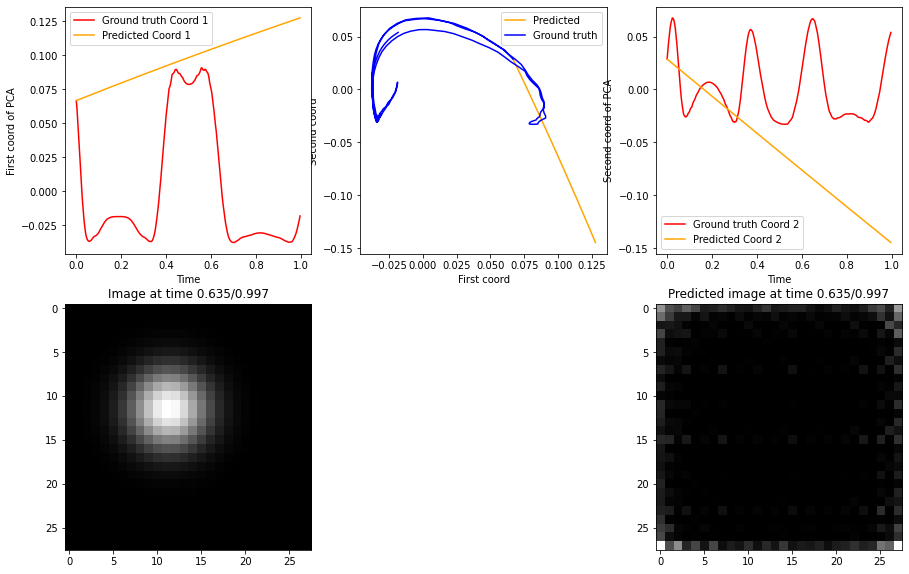

Display loss: 0.03896817:   5%|▌         | 500/10000 [03:07<1:16:09,  2.08it/s, Loss: 0.01482983]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0124, grad_fn=<MseLossBackward>)
loss_reg:  tensor(0.0024, grad_fn=<MulBackward0>)
reg_lambda:  0.0005
-------------------------------------------------------------------------


Display loss: 0.03896817:  10%|▉         | 999/10000 [06:14<56:09,  2.67it/s, Loss: 0.01200063]  

The graphs at epoch 1000


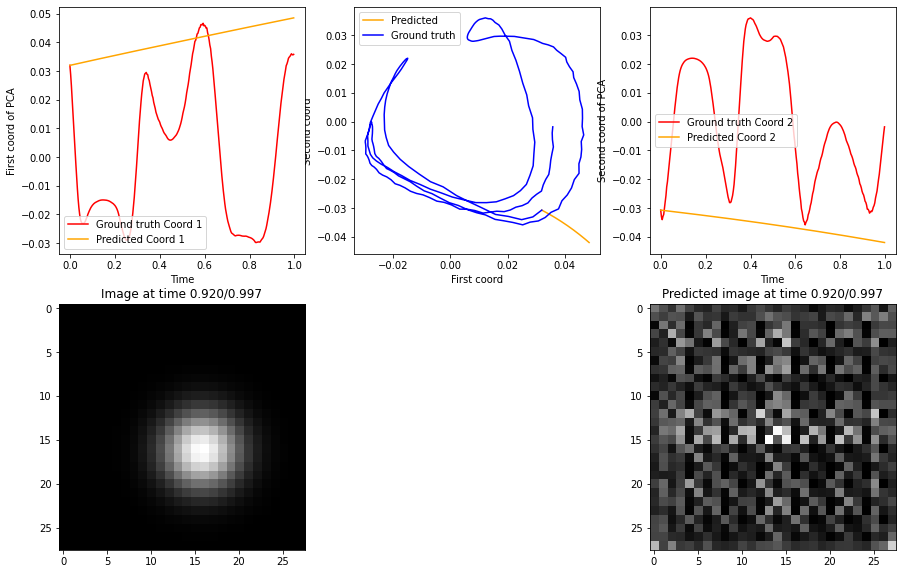

Display loss: 0.01330074:  10%|█         | 1000/10000 [06:14<1:08:53,  2.18it/s, Loss: 0.01200063]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0110, grad_fn=<MseLossBackward>)
loss_reg:  tensor(0.0008, grad_fn=<MulBackward0>)
reg_lambda:  0.0004
-------------------------------------------------------------------------


Display loss: 0.01330074:  15%|█▍        | 1499/10000 [09:21<53:03,  2.67it/s, Loss: 0.01055609]  

The graphs at epoch 1500


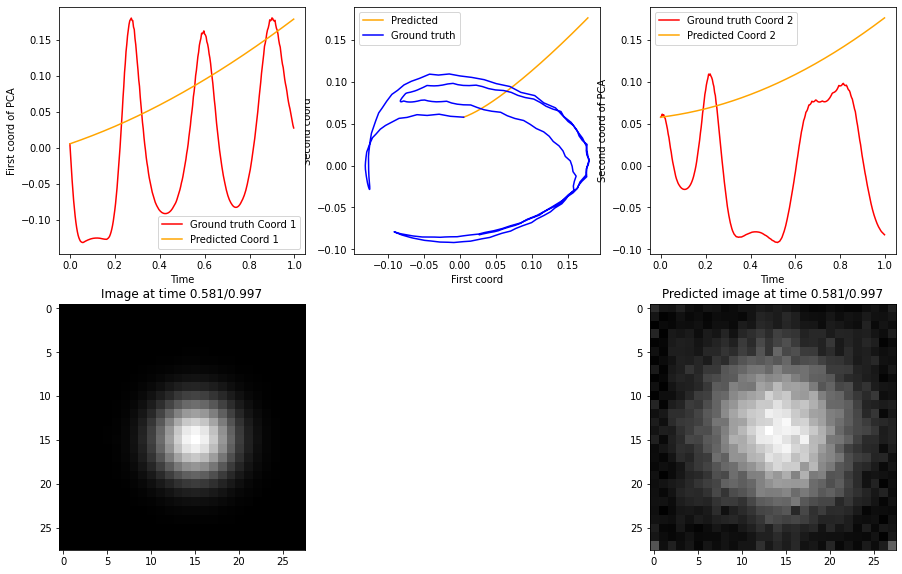

Display loss: 0.01028327:  15%|█▌        | 1500/10000 [09:22<1:05:56,  2.15it/s, Loss: 0.01055609]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0100, grad_fn=<MseLossBackward>)
loss_reg:  tensor(0.0006, grad_fn=<MulBackward0>)
reg_lambda:  0.0004
-------------------------------------------------------------------------


Display loss: 0.01028327:  20%|█▉        | 1999/10000 [12:29<50:45,  2.63it/s, Loss: 0.00928973]  

The graphs at epoch 2000


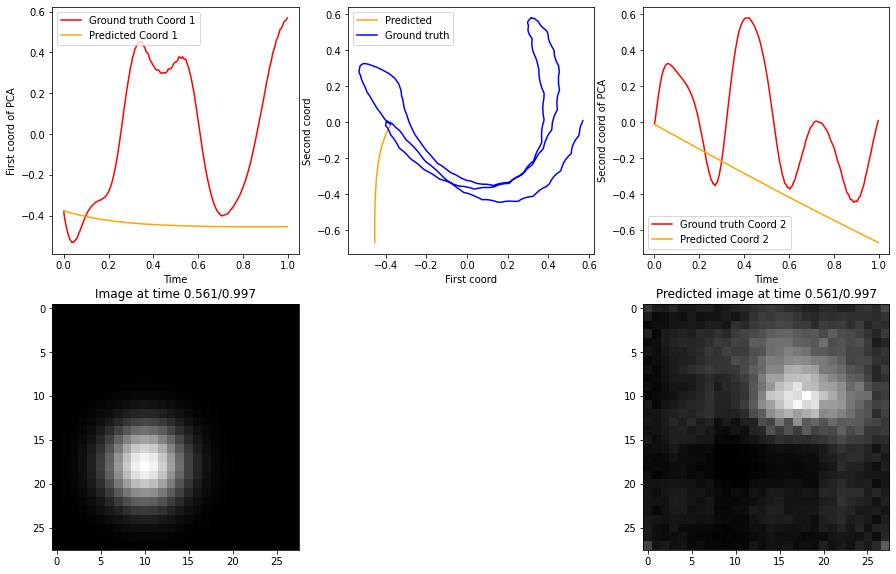

Display loss: 0.00937266:  20%|██        | 2000/10000 [12:29<1:01:32,  2.17it/s, Loss: 0.00928973]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0087, grad_fn=<MseLossBackward>)
loss_reg:  tensor(0.0005, grad_fn=<MulBackward0>)
reg_lambda:  0.00032
-------------------------------------------------------------------------


Display loss: 0.00937266:  25%|██▍       | 2499/10000 [15:36<47:01,  2.66it/s, Loss: 0.00759473]  

The graphs at epoch 2500


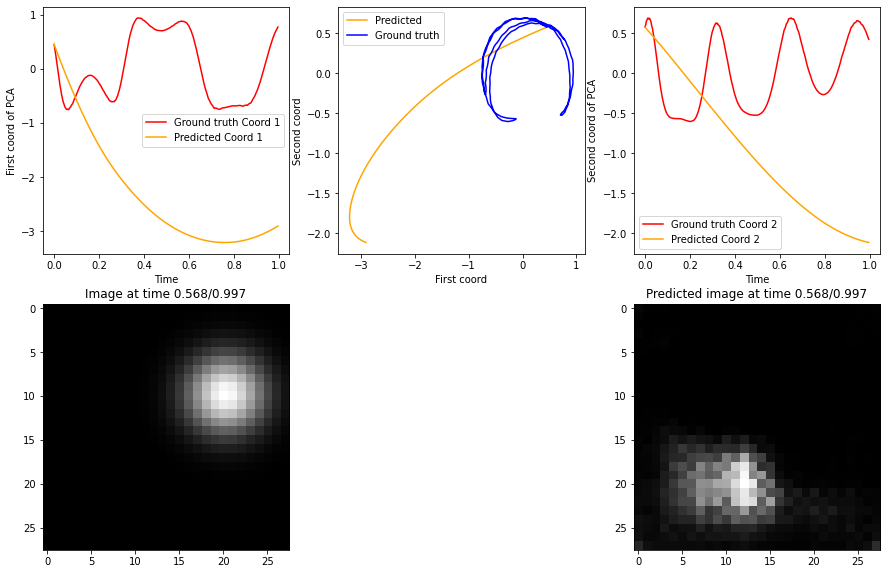

Display loss: 0.00801625:  25%|██▌       | 2500/10000 [15:36<56:55,  2.20it/s, Loss: 0.00759473]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0070, grad_fn=<MseLossBackward>)
loss_reg:  tensor(0.0006, grad_fn=<MulBackward0>)
reg_lambda:  0.00032
-------------------------------------------------------------------------


Display loss: 0.00801625:  30%|██▉       | 2999/10000 [18:44<44:04,  2.65it/s, Loss: 0.00577438]

The graphs at epoch 3000


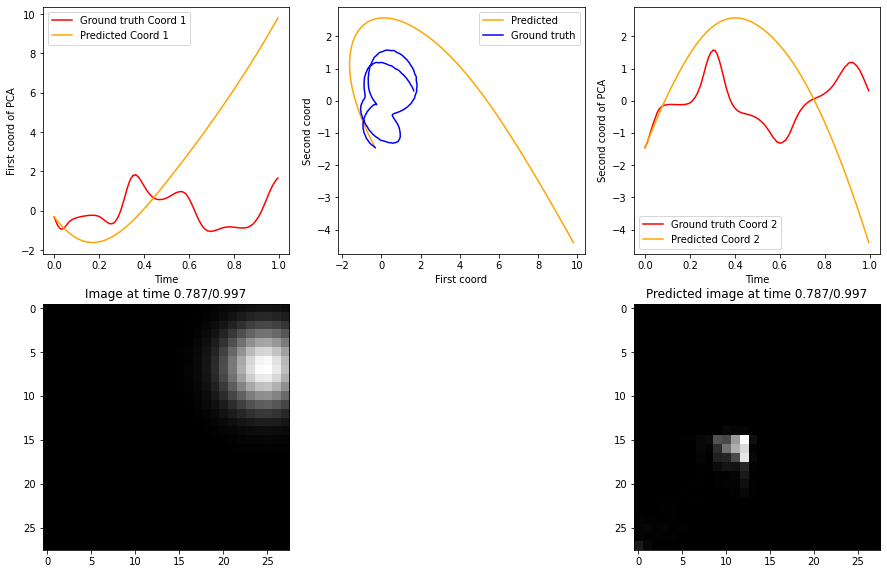

Display loss: 0.00630225:  30%|███       | 3000/10000 [18:44<52:39,  2.22it/s, Loss: 0.00577438]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0053, grad_fn=<MseLossBackward>)
loss_reg:  tensor(0.0004, grad_fn=<MulBackward0>)
reg_lambda:  0.00025600000000000004
-------------------------------------------------------------------------


Display loss: 0.00630225:  35%|███▍      | 3499/10000 [21:52<40:33,  2.67it/s, Loss: 0.00278186]

The graphs at epoch 3500


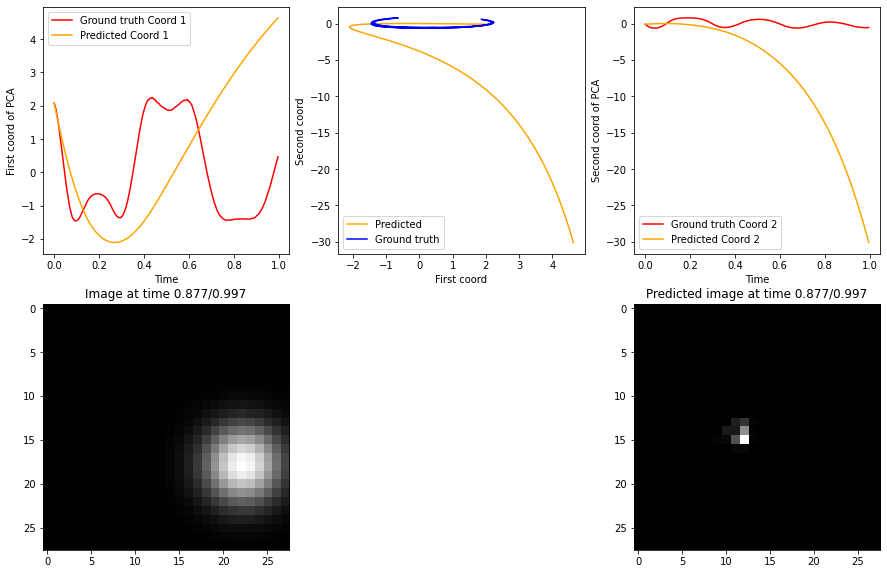

Display loss: 0.00441940:  35%|███▌      | 3500/10000 [21:52<50:46,  2.13it/s, Loss: 0.00278186]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0024, grad_fn=<MseLossBackward>)
loss_reg:  tensor(0.0004, grad_fn=<MulBackward0>)
reg_lambda:  0.00025600000000000004
-------------------------------------------------------------------------


Display loss: 0.00441940:  36%|███▌      | 3566/10000 [22:17<40:13,  2.67it/s, Loss: 0.00506088]


KeyboardInterrupt: 

In [9]:
print("-"*50)
print("Training...")
epochs = 10000
train_convnode_with_batch(conv_ode, optimizer, scheduler, epochs,
    getter, loss_fn=loss_fn, display=500, display_results_fn=display_fn)

In [60]:
from skimage.color import gray2rgb

def generate_interactive_plot(i, model, out_display, getter, final_time, dt, root=None, name=None):

    index = np.random.randint(0, getter.N_train)
    time_steps = np.linspace(0, final_time*dt, final_time)

    times = torch.arange(0, final_time*dt, dt)

    gd_images = getter.train_images[index, :-1][:,0]
    input_images = getter.train_images[index, :2]
    with torch.no_grad():
        reconstructed_images, _ = model(input_images, times, dt)
        reconstructed_images = reconstructed_images.cpu().numpy()

    print("Sim", reconstructed_images.shape, gd_images.shape)

    gd_images = np.expand_dims(gd_images, axis=1)
    reconstructed_images = np.expand_dims(reconstructed_images[:,0], axis=1)
    print("Extract Gray", gd_images.shape, reconstructed_images.shape)

    gd_images = np.array([gray2rgb(img[0]) for img in gd_images])
    gd_images = 200*(gd_images - gd_images.min())/(gd_images.max() - gd_images.min())
    print("Gray to rgb for gd_images", gd_images.shape, reconstructed_images.shape)

    reconstructed_images = np.array([gray2rgb(img[0]) for img in reconstructed_images])
    reconstructed_images = 200*(reconstructed_images - reconstructed_images.min())/(reconstructed_images.max() - reconstructed_images.min())

    print("Gray to rgb for reconstructed", gd_images.shape, reconstructed_images.shape)

    return interactive_part_trajectory_image_plot(gd_images, reconstructed_images, time_steps, dt)


def interactive_part_trajectory_image_plot(inputs_images, reconstructed_images, time_steps, dt):
    fig = make_subplots(rows=1, cols=3, subplot_titles=("Input image", "Predicted image"))
    fig = go.FigureWidget(fig)
    # add a black background to the figure
    fig.add_image(z=inputs_images[0], row=1, col=1, name='true image')
    fig.add_image(z=reconstructed_images[0], row=1, col=2, name='predicted image')

    N_max_input = len(inputs_images)-1
    N_max_predicted = len(reconstructed_images)-1
    N_max = max(N_max_input, N_max_predicted)

    frac_input = 1. #N_max/N_max_predicted
    frac_predicted = 1. #N_max/N_max_input

    @interact(t=(time_steps.min(),time_steps.max(),dt))
    def update_plot(t):
        with fig.batch_update():
            # change the current point of 
            print(t/dt)
            print(int(frac_input*t/dt))
            print(int(frac_predicted*t/dt))
            fig.data[0].z = inputs_images[min(int(frac_input*t/dt), N_max_input)]
            fig.data[1].z = reconstructed_images[min(int(frac_predicted*t/dt), N_max_predicted)]

    return fig

In [67]:
fig = generate_interactive_plot(0, conv_ode, 0, getter, N_frames - Num_pos_velocity, dt, root=None, name=None)
fig

Sim (300, 3, 28, 28) torch.Size([300, 28, 28])
Extract Gray (300, 1, 28, 28) (300, 1, 28, 28)
Gray to rgb for gd_images (300, 28, 28, 3) (300, 1, 28, 28)
Gray to rgb for reconstructed (300, 28, 28, 3) (300, 28, 28, 3)


interactive(children=(FloatSlider(value=0.4983388704318937, description='t', max=0.9966777408637874, step=0.00…

FigureWidget({
    'data': [{'name': 'true image',
              'type': 'image',
              'uid': '8e5076…